In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import itertools
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")


In [4]:
# Load data
data = pd.read_excel('calls.xlsx', parse_dates=['Date'], index_col='Date')
data = data.sort_index()
data = data.drop(columns=['Unnamed: 0'])

In [71]:
data["day_of_week"] = data.index.day_name()

In [72]:
# Define Armenian holidays 
armenian_holidays = [
'2022-01-01','2023-01-01','2024-01-01','2025-01-01','2026-01-01',
'2022-01-02','2023-01-02','2024-01-02','2025-01-02','2026-01-02',
'2022-01-06','2023-01-06','2024-01-06','2025-01-06','2026-01-06',
'2022-01-28','2023-01-28','2024-01-28','2025-01-28','2026-01-28',
'2022-03-08','2023-03-08','2024-03-08','2025-03-08','2026-03-08',
'2022-04-24','2023-04-24','2024-04-24','2025-04-24','2026-04-24',
'2022-05-01','2023-05-01','2024-05-01','2025-05-01','2026-05-01',
'2022-05-09','2023-05-09','2024-05-09','2025-05-09','2026-05-09',
'2022-05-28','2023-05-28','2024-05-28','2025-05-28','2026-05-28',
'2022-07-05','2023-07-05','2024-07-05','2025-07-05','2026-07-05',
'2022-09-21','2023-09-21','2024-09-21','2025-09-21','2026-09-21',
'2022-12-31','2023-12-31','2024-12-31','2025-12-31','2026-12-31',
]
armenian_holidays = pd.to_datetime(armenian_holidays)
# Add a column to indicate if the date is a holiday
data["is_holiday"] = data.index.isin(armenian_holidays)

In [63]:
data.head()

,answered_calls,missed_calls,unique_numbers,Call duration,time_to_next_call,number_of_unique_logins,working_time,calls_from_clients,total_calls,share_of_answered_calls,share_of_calls_from_registered_number,number_of_new_clients,number_of_new_clients_last_7_days,number_of_new_clients_last_30_days,clients,day_of_week,is_holiday
Date,,,,,,,,,,,,,,,,,
2022-03-02,1407,3335,2671,3.246457,3.910684,25,6.486056,3333.0,4742,0.296710,0.702868,329,1566,6075,317865,Wednesday,False
2022-03-03,1560,3230,2726,3.364972,4.228847,27,7.131543,3579.0,4790,0.325678,0.747182,341,1619,6115,318192,Thursday,False
2022-03-04,1576,3197,2724,3.180913,3.836560,28,6.370833,3789.0,4773,0.330191,0.793840,313,1655,6206,318484,Friday,False
2022-03-05,775,1297,1353,3.555806,4.663760,15,6.983167,1551.0,2072,0.374035,0.748552,112,1695,6116,318592,Saturday,False
2022-03-06,458,870,841,3.515138,5.388176,7,9.504722,932.0,1328,0.344880,0.701807,145,1798,6005,318732,Sunday,False


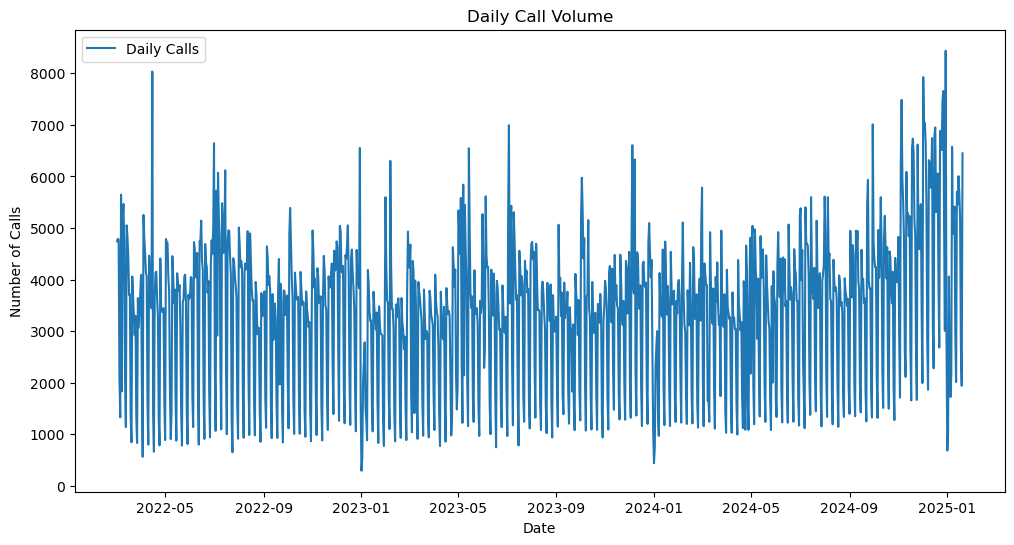

In [73]:
plt.figure(figsize=(12, 6))
plt.plot(data['total_calls'], label='Daily Calls')
plt.title('Daily Call Volume')
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.legend()
plt.show()

In [74]:
data.shape

(1056, 17)

In [44]:
data.columns

Index(['answered_calls', 'missed_calls', 'unique_numbers', 'Call duration',
       'time_to_next_call', 'number_of_unique_logins', 'working_time',
       'calls_from_clients', 'total_calls', 'share_of_answered_calls',
       'share_of_calls_from_registered_number', 'number_of_new_clients',
       'number_of_new_clients_last_7_days',
       'number_of_new_clients_last_30_days', 'clients', 'day_of_week',
       'is_holiday'],
      dtype='object')

In [64]:
data["total_calls"] = pd.to_numeric(data["total_calls"], errors="coerce")

In [46]:
# Aggregate daily total_calls for prediction
time_series = data["total_calls"].resample("D").sum()

In [47]:
time_series

Date
2022-03-02    4742.0
2022-03-03    4790.0
2022-03-04    4773.0
2022-03-05    2072.0
2022-03-06    1328.0
               ...  
2025-01-17    5175.0
2025-01-18    2699.0
2025-01-19    1940.0
2025-01-20    6447.0
2025-01-21       0.0
Freq: D, Name: total_calls, Length: 1057, dtype: float64

In [48]:
# Check stationarity (Augmented Dickey-Fuller test)
def check_stationarity(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary. Differencing may be required.")

In [49]:
check_stationarity(time_series)

ADF Statistic: -3.1906380149462366
p-value: 0.020533023473132718
The series is stationary.


In [50]:
# If not stationary, apply differencing (uncomment if needed)
# time_series = time_series.diff().dropna()

In [53]:
# Train-test split (last 3 months for validation)
train_size = int(len(time_series) * 0.9)
train, test = time_series[:train_size], time_series[train_size:]

In [54]:
# SARIMA parameter grid search
p = d = q = range(0, 3)
seasonal_p = seasonal_d = seasonal_q = range(0, 3)
seasonal_period = [7] # Weekly seasonality
# Generate all parameter combinations
sarima_params = list(itertools.product(p, d, q))
seasonal_params = list(itertools.product(seasonal_p, seasonal_d, seasonal_q, seasonal_period))
best_aic = float("inf")
best_order = None
best_seasonal_order = None

In [55]:
for param in sarima_params:
    for seasonal_param in seasonal_params:
        try:
            model = SARIMAX(train, order=param, seasonal_order=seasonal_param, enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = seasonal_param
        except:
            continue
print("Best SARIMA Order:", best_order)
print("Best Seasonal Order:", best_seasonal_order)

Best SARIMA Order: (0, 1, 2)
Best Seasonal Order: (0, 2, 2, 7)


In [56]:
# Fit the best SARIMA model
final_model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
final_results = final_model.fit(disp=False)

In [57]:
# Forecast for 3 months
forecast_steps = 90 # 3 months
forecast = final_results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
# Calculate total predicted calls for the next 3 months
total_forecast_calls = forecast_mean.sum()
# Evaluate the model
test_forecast = final_results.get_forecast(steps=len(test))
test_forecast_mean = test_forecast.predicted_mean
rmse = np.sqrt(mean_squared_error(test, test_forecast_mean))
print(f"RMSE on validation set: {rmse}")

RMSE on validation set: 1428.0737080288447


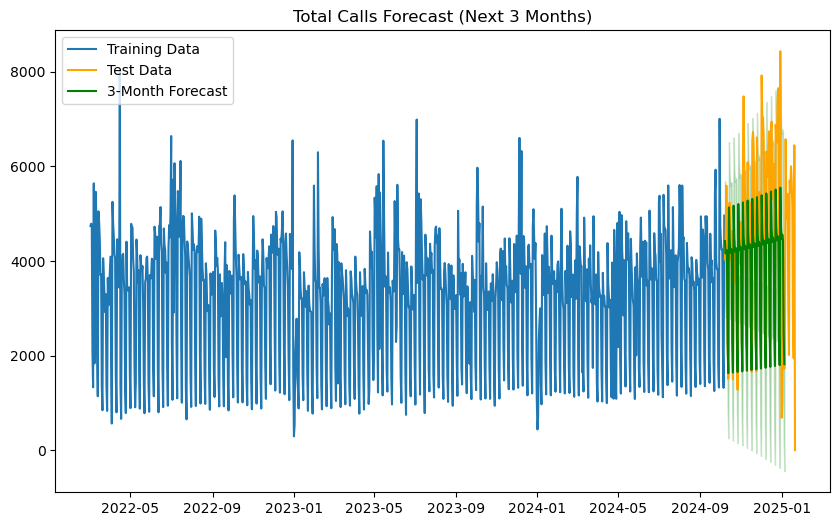

Total forecasted calls for the next 3 months: 346134.6051976913


In [58]:
# Plot the forecast
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train, label="Training Data")
plt.plot(test, label="Test Data", color="orange")
plt.plot(forecast_mean, label="3-Month Forecast", color="green")
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color="green", alpha=0.2)
plt.legend(loc="upper left")
plt.title("Total Calls Forecast (Next 3 Months)")
plt.show()
print(f"Total forecasted calls for the next 3 months: {total_forecast_calls}")

In [75]:
data.columns

Index(['answered_calls', 'missed_calls', 'unique_numbers', 'Call duration',
       'time_to_next_call', 'number_of_unique_logins', 'working_time',
       'calls_from_clients', 'total_calls', 'share_of_answered_calls',
       'share_of_calls_from_registered_number', 'number_of_new_clients',
       'number_of_new_clients_last_7_days',
       'number_of_new_clients_last_30_days', 'clients', 'day_of_week',
       'is_holiday'],
      dtype='object')

In [82]:
data['is_holiday'] = LabelEncoder().fit_transform(data['is_holiday'])

In [85]:
data['day_of_week'] = LabelEncoder().fit_transform(data['day_of_week'])

In [87]:
data[data.columns] = data[data.columns].apply(pd.to_numeric, errors="coerce")

In [89]:
data["total_calls"] = pd.to_numeric(data["total_calls"], errors="coerce")

In [99]:
data = data.apply(lambda col:col.fillna(col.mean()), axis=0)

In [90]:
# Aggregate daily total_calls for prediction
time_series = data["total_calls"].resample("D").sum()

In [91]:
check_stationarity(time_series)

ADF Statistic: -2.9503251444641823
p-value: 0.03980107149429979
The series is stationary.


In [100]:
train_size = int(len(time_series) * 0.9)
train, test = time_series[:train_size], time_series[train_size:]

In [101]:
# Train-test split for exogenous variables
exog_train = data[data.columns][:train_size]
exog_test = data[data.columns][train_size:]

In [ ]:
# SARIMA parameter grid search
p = d = q = range(0, 3)
seasonal_p = seasonal_d = seasonal_q = range(0, 3)
seasonal_period = [7] # Weekly seasonality
# Generate all parameter combinations
sarima_params = list(itertools.product(p, d, q))
seasonal_params = list(itertools.product(seasonal_p, seasonal_d, seasonal_q, seasonal_period))
best_aic = float("inf")
best_order = None
best_seasonal_order = None
for param in sarima_params:
    for seasonal_param in seasonal_params:
        try:
            model = SARIMAX(
            train, exog=exog_train, order=param, seasonal_order=seasonal_param,
            enforce_stationarity=False, enforce_invertibility=False
            )
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = seasonal_param
        except:
            continue
print("Best SARIMA Order:", best_order)
print("Best Seasonal Order:", best_seasonal_order)

In [103]:
# Fit the best SARIMA model
final_model = SARIMAX(
train, exog=exog_train, order=best_order, seasonal_order=best_seasonal_order,
enforce_stationarity=False, enforce_invertibility=False
)
final_results = final_model.fit(disp=False)

In [106]:
# Forecast for 3 months
forecast_steps = 90 # 3 months
future_exog = data[data.columns].iloc[-forecast_steps:] # Provide future values if known
forecast = final_results.get_forecast(steps=forecast_steps, exog=future_exog)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
# Calculate total predicted calls for the next 3 months
total_forecast_calls = forecast_mean.sum()
# Evaluate the model
test_forecast = final_results.get_forecast(steps=len(test), exog=exog_test)
test_forecast_mean = test_forecast.predicted_mean
rmse = np.sqrt(mean_squared_error(test, test_forecast_mean))
print(f"RMSE on validation set: {rmse}")

RMSE on validation set: 1.4220591707730046e-06


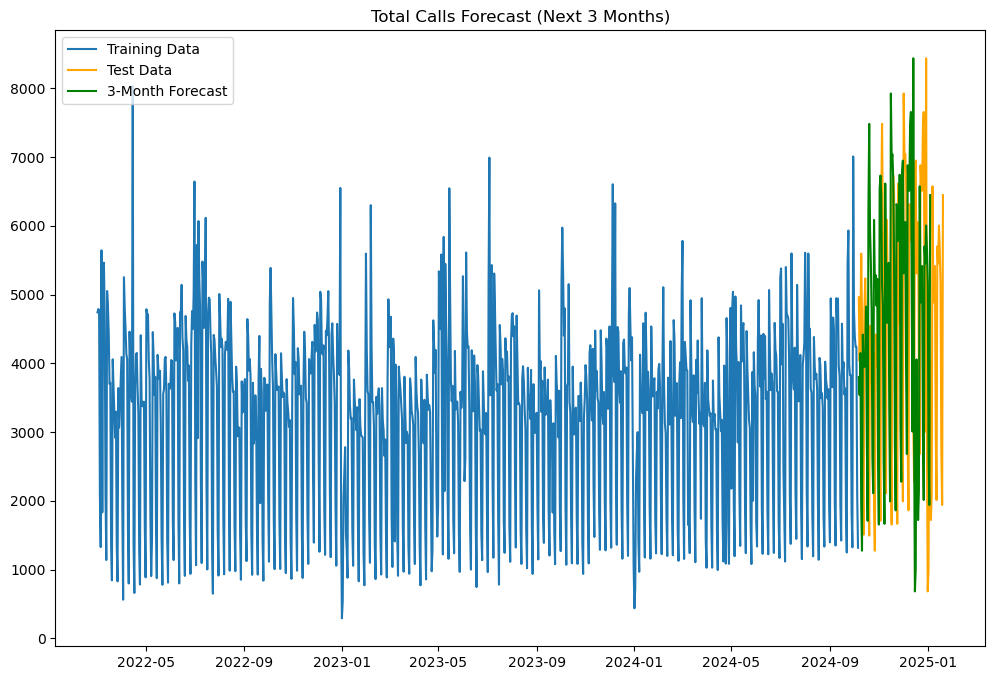

Total forecasted calls for the next 3 months: 417547.00011876517


In [107]:
# Plot the forecast
plt.figure(figsize=(12, 8))
plt.plot(train, label="Training Data")
plt.plot(test, label="Test Data", color="orange")
plt.plot(forecast_mean, label="3-Month Forecast", color="green")
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color="green", alpha=0.2)
plt.legend(loc="upper left")
plt.title("Total Calls Forecast (Next 3 Months)")
plt.show()
print(f"Total forecasted calls for the next 3 months: {total_forecast_calls}")

In [108]:
final_results

In [109]:
 forecast.predicted_mean

2024-10-07    3800.000001
2024-10-08    3539.000001
2024-10-09    4150.000001
2024-10-10    1943.000001
2024-10-11    1276.000001
                 ...     
2024-12-31    5676.000002
2025-01-01    5175.000002
2025-01-02    2699.000002
2025-01-03    1940.000002
2025-01-04    6447.000002
Freq: D, Name: predicted_mean, Length: 90, dtype: float64

In [111]:
exog_full = data[data.columns]
finall = SARIMAX(
time_series, exog=exog_full, order=best_order, seasonal_order=best_seasonal_order,
enforce_stationarity=False, enforce_invertibility=False
)
final_results = finall.fit(disp=False)

In [115]:
forecast = final_results.get_forecast(steps=90, exog=future_exog)
forecast_mean = forecast.predicted_mean

In [116]:
last_date = data.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=90+1, freq='D')[1:]

forecast_df = pd.DataFrame({
    'Date':forecast_dates, 
    'Total Calls': forecast_mean.values
})

In [117]:
forecast_df

,Date,Total Calls
0,2025-01-21,3800.0
1,2025-01-22,3539.0
2,2025-01-23,4150.0
3,2025-01-24,1943.0
4,2025-01-25,1276.0
...,...,...
85,2025-04-16,5676.0
86,2025-04-17,5175.0
87,2025-04-18,2699.0
88,2025-04-19,1940.0


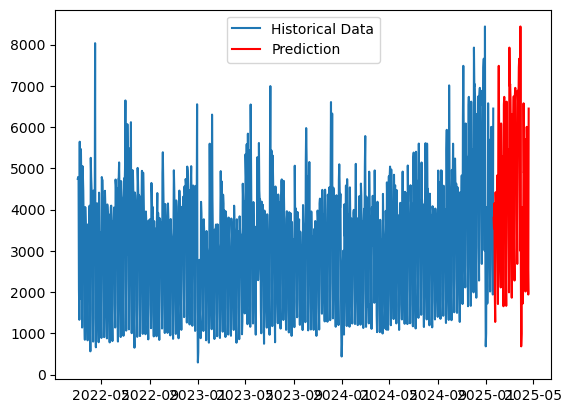

In [118]:
plt.plot(data.index, data['total_calls'], label = 'Historical Data')
plt.plot(forecast_df['Date'], forecast_df['Total Calls'], label='Prediction', color='red')
plt.legend()
plt.show()

In [119]:
forecast_df['Total Calls'].sum()

417547.0000000039